### 1.0.0 Coffee Project

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.python.keras.models import Input
from tensorflow.keras.layers import BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import regularizers

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [54]:
import sys
sys.path.append("../content/drive/MyDrive/Proyectos/Proyectos/Project-Brazil") 

from utils.utils import read_images_drive, evaluate_model, matconfision

from utils.paths2 import direcciones_colab
G_raw, G_processed, G_interim, G_external, G_models, G_reports, G_reports_figures = direcciones_colab('brazil')

1.0.1 Load data

In [55]:
# load data
dirname = os.path.join(G_interim, 'fotos2')
imgpath = dirname + os.sep

images, directories, dircount, labels, cafes = read_images_drive(imgpath)

Directorios leidos:  8
Imagenes en cada directorios [70, 90, 191, 200, 200, 123, 101, 114]
Suma total de imagenes en subdirs 1089
Cantidad etiquetas creadas:  1089


### 1.0.2 Pre-train

In [56]:
# convertir array las images y labels
y = np.array(labels)
X = np.array(images)

In [57]:
# categorias existentes, numero de categorias diferentes
classes = np.unique(y)
nClasses = len(classes)
nClasses, classes

(8, array([0, 1, 2, 3, 4, 5, 6, 7]))

In [58]:
# train, test and validation
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size = 0.2)
print('Training data shape: ', train_X.shape, train_Y.shape)
print('Test data shape: ', test_X.shape, test_Y.shape)

Training data shape:  (871, 28, 28, 3) (871,)
Test data shape:  (218, 28, 28, 3) (218,)


In [59]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

# Normalizate
train_X = train_X / 255.
test_X = test_X / 255.

In [60]:
# cambio a categorico
train_Y_one_hot = to_categorical(train_Y)
test_y_one_hot = to_categorical(test_Y)

# verigicacion
print('Original label: ', train_Y[0])
print('After: ', train_Y_one_hot[0])

Original label:  4
After:  [0. 0. 0. 0. 1. 0. 0. 0.]


### 1.0.3 Show some images

Text(0.5, 1.0, 'Ground Truth: 1')

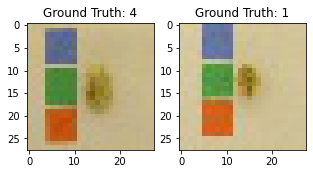

In [61]:
plt.figure(figsize = [5,5])

# primera imagen de training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap = 'gray')
plt.title('Ground Truth: {}'.format(train_Y[0]))

# primera imagen de training data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap = 'gray')
plt.title('Ground Truth: {}'.format(test_Y[0]))

### 1.0.3 model CNN

Se utilizo Keras dada su facilidad de uso. De multiples pruebas se decidio tomar los siguientes valores en los respectivos hiperparametros:

* Taza de aprendizaje de 0.005
* 100 Epocas
* Batch size de 64.
* Optimizador: Adagrad

La arquitectura elegida es de 6 capas convolucionales con multiples dropout para evitar el sobre entrenamiento y funciones de activacion relu, en la segunda parte se aplana y se crea una red neuronal densa de 32 neuronas en la primera capa con una salida softmax de 8 neuronas que corresponden a la salida del one hot encoding.

La arquitectura completa cuenta con 410,344 parametros a entrenar, con un tiempo estimado de 10 minutos, este tiempo se puede reducir si se entrena en la nube por ejemplo en el Colab de google.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y_one_hot, test_size = 0.2, random_state = 123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(696, 28, 28, 3) (175, 28, 28, 3) (696, 8) (175, 8)


In [63]:
# taza de aprendizaje
init_lr = 0.005
# iteraciones por conjnto de entrenamiento
epochs = 100
# cantidad de imagenes que se toman a la vez en memoria
batch_size = 64

In [64]:
model = Sequential()
model.add(Conv2D(16, kernel_size = [3, 3], padding = "same", activation = "relu", input_shape = (28, 28, 3)))
model.add(Conv2D(32, kernel_size = [3, 3], padding = "same", activation = "relu"))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size = [3, 3]))
model.add(Conv2D(32, kernel_size = [3, 3], padding = "same", activation = "relu"))
model.add(Conv2D(64, kernel_size = [3, 3], padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = [3, 3]))
model.add(Conv2D(128, kernel_size = [3, 3], padding = "same", activation = "relu"))
model.add(Conv2D(256, kernel_size = [3, 3], padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = [3, 3]))
model.add(Dropout(0.5))
# model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(nClasses, activation = "softmax"))

In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 dropout_8 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 9, 9, 32)          9248      
                                                                 
 conv2d_15 (Conv2D)          (None, 9, 9, 64)          18496     
                                                      

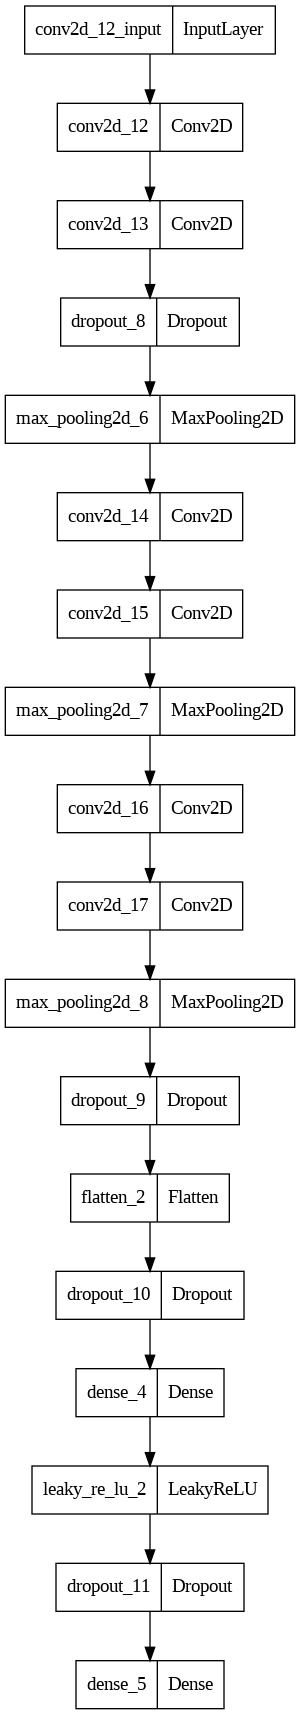

In [66]:
plot_model(model)

In [67]:
model.compile(loss = keras.losses.categorical_crossentropy, 
              optimizer = keras.optimizers.Adagrad(lr = init_lr, decay = init_lr / 100), 
              metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


In [68]:
model_fit = model.fit(X_train, y_train, 
                      batch_size = batch_size,
                      epochs = epochs,
                      verbose = 1,
                      validation_data = (X_test, y_test))

Epoch 1/100
11/11 [==============================] - 5s 372ms/step - loss: 2.1492 - accuracy: 0.1078 - val_loss: 2.1334 - val_accuracy: 0.1486
Epoch 2/100
11/11 [==============================] - 3s 222ms/step - loss: 2.1354 - accuracy: 0.1451 - val_loss: 2.1309 - val_accuracy: 0.1486
Epoch 3/100
11/11 [==============================] - 2s 198ms/step - loss: 2.1248 - accuracy: 0.1724 - val_loss: 2.1276 - val_accuracy: 0.1486
Epoch 4/100
11/11 [==============================] - 2s 200ms/step - loss: 2.1198 - accuracy: 0.1839 - val_loss: 2.1245 - val_accuracy: 0.1486
Epoch 5/100
11/11 [==============================] - 2s 196ms/step - loss: 2.1200 - accuracy: 0.1954 - val_loss: 2.1230 - val_accuracy: 0.1886
Epoch 6/100
11/11 [==============================] - 2s 195ms/step - loss: 2.1060 - accuracy: 0.2126 - val_loss: 2.1203 - val_accuracy: 0.2114
Epoch 7/100
11/11 [==============================] - 2s 195ms/step - loss: 2.1055 - accuracy: 0.1695 - val_loss: 2.1184 - val_accuracy: 0.1771

In [69]:
# Guardar los pesos del modelo
model.save(G_models/'model_fit_1.h5py')

In [70]:
#from keras.models import load_model
#model_fit = load_model(G_models/'model_fit_1.h5py')
#model.summary()

### 1.0.4 Resultados

In [71]:
test_eval = model.evaluate(test_X, test_y_one_hot, verbose = 1)

7/7 [==============================] - 0s 21ms/step - loss: 1.0652 - accuracy: 0.7110


In [72]:
print('Test loss: ', test_eval[0])
print('Test accuracy: ', test_eval[1])

Test loss:  1.0652129650115967
Test accuracy:  0.71100914478302


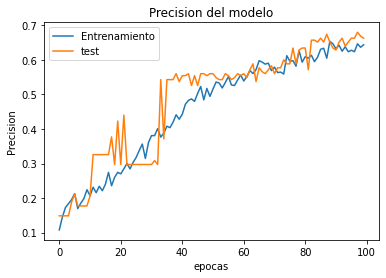

In [73]:
# hacemos las grafica 1 precision
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('Precision del modelo')
plt.ylabel('Precision')
plt.xlabel('epocas')
plt.legend(['Entrenamiento', 'test'], loc='upper left')
plt.show()

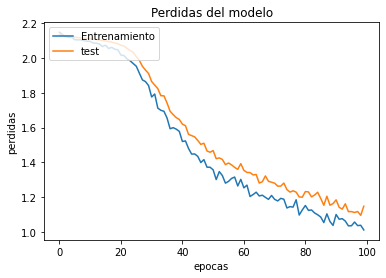

In [74]:
# hacemos las grafica 2 perdidas
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Perdidas del modelo')
plt.ylabel('perdidas')
plt.xlabel('epocas')
plt.legend(['Entrenamiento', 'test'], loc='upper left')
plt.show()

In [75]:
# prediccion del conjunto test_X
predicted_classes2 = model.predict(test_X)

7/7 [==============================] - 0s 23ms/step


In [76]:
# lista para guardar las predicciones
predicted_classes = []
for predicted_s in predicted_classes2:
    predicted_classes.append(predicted_s.tolist().index(max(predicted_s)))
predicted_classes = np.array(predicted_classes)

In [77]:
# Predicciones
predicted_classes.shape, test_Y.shape

((218,), (218,))

In [78]:
# verificacion de las predicciones correctas
correct = np.where(predicted_classes == test_Y)[0]
print('Se encontraron {} predicciones correctas'.format(len(correct)))

Se encontraron 155 predicciones correctas


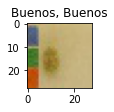

In [79]:
# grafico de predicciones correctas
for i, correct in enumerate(correct[0:1]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct], cmap = 'gray')
    plt.title('{}, {}'.format(cafes[predicted_classes[correct]],
                              cafes[test_Y[correct]]))
    plt.tight_layout()

In [80]:
# verificacion de las predicciones INcorrectas
incorrect = np.where(predicted_classes != test_Y)[0]
print('Se encontraron {} predicciones INcorrectas'.format(len(incorrect)))

Se encontraron 63 predicciones INcorrectas


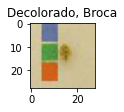

In [81]:
# grafico de predicciones INcorrectas
for i, incorrect in enumerate(incorrect[0:1]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect], cmap = 'gray')
    plt.title('{}, {}'.format(cafes[predicted_classes[incorrect]],
                              cafes[test_Y[incorrect]]))
    plt.tight_layout()

In [82]:
# resumen de estadisticos
target_names = ['class {}'.format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00        14
     class 1       0.00      0.00      0.00        18
     class 2       0.97      1.00      0.99        36
     class 3       0.48      0.95      0.64        41
     class 4       0.98      0.92      0.95        48
     class 5       0.55      0.96      0.70        24
     class 6       1.00      0.93      0.96        14
     class 7       0.00      0.00      0.00        23

    accuracy                           0.71       218
   macro avg       0.50      0.59      0.53       218
weighted avg       0.59      0.71      0.63       218



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


El f1 score es de:  0.6300370326450953
El acc score es de:  0.7110091743119266
La precision es de:  0.7110091743119266
El f1 score es de:  0.7110091743119266


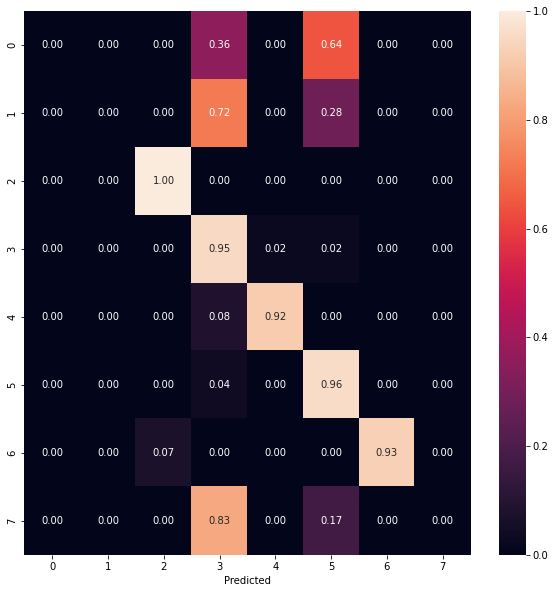

In [83]:
# Metricas
evaluate_model(test_Y, predicted_classes)
matconfision(test_Y, predicted_classes)